In [ ]:
from torch import nn
import torch
import numpy as np
import types

def set_multiplier(layer, g):
    if not hasattr(layer, '_base_fwd'):
        layer._base_fwd = layer.forward
    layer._multiplier = g
    new_fwd = lambda slf, x: slf._multiplier * slf._base_fwd(x)
    layer.forward = types.MethodType(new_fwd, layer)

def set_init_scale(layer, scale):
    assert layer.weight is not None
    with torch.no_grad():
        layer.weight.normal_(0, scale)
        if layer.bias is not None:
            layer.bias.normal_(0, scale)

def set_lr(optimizer, layer, lr):
    # One-time setup
    if not hasattr(optimizer, '_base_lr'):
        assert len(optimizer.param_groups) == 1
        # Save base LR and save other optimizer settings
        hypers = {}
        for k, v in optimizer.param_groups[0].items():
            if k != 'params':
                if k == 'lr':
                    optimizer._base_lr = optimizer.param_groups[0]['lr']
                hypers[k] = v
        assert hasattr(optimizer, '_base_lr')
        # Create separate param group for each param and transfer other optimizer settings
        new_pgs = []
        for param in optimizer.param_groups[0]['params']:
            pg = hypers.copy()
            pg['params'] = [param]
            new_pgs.append(pg)
        optimizer.param_groups = new_pgs

    # Update lr for all parameters in given layer
    lr = optimizer._base_lr * lr
    for pg in optimizer.param_groups:
        assert len(pg['params']) == 1
        if id(pg['params'][0]) in [id(p) for p in layer.parameters()]:
            pg['lr'] = lr

# Given layer and parameterization, get layer multiplier, layer LR, and layer weight scale
def get_param(layer_type, param, layer_din, width):
    assert layer_type in ["readin", "hidden", "readout"]
    param = param.lower()
    assert param in ["ntp", "mup", "mfp", "ntp-lr", "mup-lr"]

    activity = np.sqrt(width) if param in ["mup", "mfp", "mup-lr"] else 1
    if layer_type in ["readin", "hidden"]:
        q = activity**2/layer_din
    elif layer_type == "readout":
        q = 1/layer_din

    if param in ['mup-lr', 'ntp-lr']:
        g = 1
        lr = q
        scale = np.sqrt(q) / activity
    elif param == 'mup':
        g = np.sqrt(q)
        lr = 1
        scale = 1 / activity
    elif param in ['mfp', 'ntp']:
        g = np.sqrt(q) / activity
        lr = activity**2
        scale = 1
    assert (activity * scale)**2 - lr < 1e-10
    assert (g*scale*activity)**2 - q  < 1e-10
    return g, lr, scale

# Tag the readin and readout layers; compute model width and tag it to the model
def mark_anatomy(model, verbose):
    if hasattr(model, '_modelwidth'):
        return
    widths = []
    layers = []
    for k, v in model.named_modules():
        if not hasattr(v, 'weight'):
            continue
        assert type(v) in [nn.Linear, nn.Conv2d], f"Can't handle module {k} of type {v}"
        chan_out, chan_in = v.weight.shape[0], v.weight.shape[1]
        if len(layers) == 0:
            widths.append(chan_in)
        widths.append(chan_out)
        layers.append((k, v))

    assert len(layers) > 1, f"Model must be deeper"
    layers[0][1]._layertype = "readin"
    layers[-1][1]._layertype = "readout"
    for _, layer in layers[1:-1]:
        layer._layertype = "hidden"
    model._modelwidth = np.max(widths[1:-1])

    if verbose:
        print("== Model anatomy ==")
        print(f"d_in = {widths[0]}")
        print(f"d_out = {widths[-1]}")
        print(f"widths: {widths[1:-1]}")
        print(f"\t using width = {model._modelwidth}")
        print(f"readin layer: {layers[0][0]}")
        print(f"readout layer: {layers[-1][0]}")
        print()


def mupify(model, optimizer, param, verbose=False):
    """
    Reinitializes a model+optimizer in-place to a chosen parameterization. Function does not return.

    Params:
        model (nn.Module): model whose layer multipliers and init weights to mupify.
        optimizer (optim.SGD): SGD optimizer. (Other optimizers not tested and probably don't work.)
        param (str): One of ["ntp", "mup", "mfp", "ntp-lr", "mup-lr"].
        verbose (bool): If True, prints model anatomy.
    """
    mark_anatomy(model, verbose)
    for _, v in model.named_modules():
        if type(v) == nn.ReLU:
            set_multiplier(v, np.sqrt(2))
        if not hasattr(v, 'weight'):
            continue
        wt_d_in = np.prod(v.weight.shape[1:])
        g, lr, scale = get_param(v._layertype, param, wt_d_in, model._modelwidth)
        set_multiplier(v, g)
        set_init_scale(v, scale)
        set_lr(optimizer, v, lr)


def rescale(model, gamma):
    """
    Rescales the outputs of the model by 1/gamma, i.e, gamma>1 shrinks the outputs.
    """
    mark_anatomy(model, verbose=False)
    readout = None
    for _, v in model.named_modules():
        if hasattr(v, '_layertype') and v._layertype == "readout":
            readout = v
    assert hasattr(readout, '_multiplier')
    readout._rescale = readout._multiplier / gamma
    new_fwd = lambda slf, x: slf._rescale * slf._base_fwd(x)
    readout.forward = types.MethodType(new_fwd, readout)


In [ ]:
import matplotlib.pyplot as plt

# Disable LaTeX rendering
plt.rcParams['text.usetex'] = False

# Your plotting code here


In [ ]:
import numpy as np
import torch
from torch import nn
import torch.nn.functional as F
import torchvision


import matplotlib.pyplot as plt

# plt.rc("figure", dpi=100, facecolor=(1, 1, 1))
# plt.rc("font", family='stixgeneral', size=14)
# plt.rc("axes", facecolor=(1, .99, .95), titlesize=18)
# plt.rc("mathtext", fontset='cm')
# plt.rc('text', usetex=True)
# plt.rc('text.latex', preamble=
#        r"""\usepackage{bm}
#        \usepackage{physics}""")
# Define variables for customization
import matplotlib.pyplot as plt

# Default values for rcParams
figure_dpi = 100  # Default figure DPI
figure_facecolor = 'white'  # Default figure background color
font_family = 'sans-serif'  # Default font family
font_size = 12  # Default font size
axes_facecolor = 'white'  # Default axes background color
axes_titlesize = 14  # Default title font size
mathtext_fontset = 'custom'  # Default math text font (no specific font set)
usetex = False  # Default is False, LaTeX rendering is disabled

# Modify rcParams using the default values
plt.rcParams['figure.dpi'] = figure_dpi  # Default figure DPI
plt.rcParams['figure.facecolor'] = figure_facecolor  # Default figure background color
plt.rcParams['font.family'] = font_family  # Default font family
plt.rcParams['font.size'] = font_size  # Default font size
plt.rcParams['axes.facecolor'] = axes_facecolor  # Default axes background color
plt.rcParams['axes.titlesize'] = axes_titlesize  # Default title font size
plt.rcParams['mathtext.fontset'] = mathtext_fontset  # Default math text font
plt.rcParams['text.usetex'] = usetex  # Default is False (LaTeX rendering is disabled)


In [ ]:
class ImageData():

    dataset_dict = {
        'mnist': torchvision.datasets.MNIST,
        'fmnist': torchvision.datasets.FashionMNIST,
        'cifar10': torchvision.datasets.CIFAR10,
        'cifar100': torchvision.datasets.CIFAR100
    }

    def __init__(self, dataset_name, data_dir):

        assert dataset_name in self.dataset_dict
        self.name = dataset_name

        def format_data(dataset):
            if self.name in ['cifar10','cifar100']:
                X, y = dataset.data, dataset.targets
                X = X.transpose(0, 3, 1, 2)
            if self.name in ['mnist', 'fmnist']:
                X, y = dataset.data.numpy(), dataset.targets.numpy()
                X = X[:, None, :,:]
            X = X/255.0
            y = F.one_hot(torch.Tensor(y).long()).numpy()
            return X.astype(np.float32), y.astype(np.float32)

        raw_train = self.dataset_dict[self.name](root=data_dir, train=True, download=True)
        raw_test = self.dataset_dict[self.name](root=data_dir, train=False, download=True)

        # process raw datasets
        self.train_X, self.train_y = format_data(raw_train)
        self.test_X, self.test_y = format_data(raw_test)

    def get_dataset(self, n, get="train"):
        n = int(n)
        assert n > 0
        assert get in ["train", "test"]
        full_X, full_y = (self.train_X, self.train_y) if get == "train" else (self.test_X, self.test_y)
        X, y = full_X[:n].copy(), full_y[:n].copy()
        return X, y

In [ ]:
def test_error(model, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            output = model(data)
            d_out = output.shape[1]
            test_loss += F.mse_loss(output, target, reduction='sum').item() / d_out
            pred = output.argmax(dim=1)
            correct += (pred==target.argmax(dim=1)).sum().item()
    test_loss /= len(test_loader.dataset)
    accuracy = correct / len(test_loader.dataset)
    return test_loss, accuracy

In [ ]:
def print_model_measurements(model, optimizer, input):
    print("== Output scale ==")
    print(f"{model(input).std().item():.4f}")
    print()

    print("== Init weight scale ==")
    for k, v in model.named_modules():
        if not hasattr(v, 'weight'):
            continue
        print(f"{k:<20} {v.weight.std().item():.4f}")
    print()

    print("== Layerwise learning rates ==")
    for name, param in model.named_parameters():
        if 'bias' in name:
            continue
        name = name[:-7]
        for pg in optimizer.param_groups:
            if id(param) in [id(p) for p in pg['params']]:
                print(f"{name:<20} {pg['lr']:.4f}")

In [ ]:
class SimpleMLP(nn.Module):

    def __init__(self, d_in, d_out, width):
        super().__init__()
        self.fc1 = nn.Linear(d_in, width)
        self.fc2 = nn.Linear(width, width)
        self.fc3 = nn.Linear(width, d_out)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.fc3(x)
        return x

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
param = 'mup-lr'    # choose one of ["ntp", "mup", "mfp", "ntp-lr", "mup-lr"].

model = SimpleMLP(d_in=784, d_out=10, width=512).to(device)
optimizer = torch.optim.SGD(model.parameters(), lr=1, momentum=0.9)
mupify(model, optimizer, param=param, verbose=True)

inp = torch.normal(0, 1, size=(256, 784)).cuda()
print_model_measurements(model, optimizer, inp)

== Model anatomy ==
d_in = 784
d_out = 10
widths: [512, 512]
	 using width = 512
readin layer: fc1
readout layer: fc3

== Output scale ==
0.0407

== Init weight scale ==
fc1                  0.0357
fc2                  0.0441
fc3                  0.0019

== Layerwise learning rates ==
fc1                  0.6531
fc2                  1.0000
fc3                  0.0020


In [ ]:
imdata = ImageData("mnist", 'data')
X_train, y_train = imdata.get_dataset(5000, get='train')
X_test, y_test = imdata.get_dataset(5000, get='test')
X_train = X_train.reshape(X_train.shape[0], -1)
X_test = X_test.reshape(X_test.shape[0], -1)
X_train, y_train, X_test, y_test = [torch.Tensor(d).cuda() for d in (X_train, y_train, X_test, y_test)]

train_loader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(X_train, y_train),
                                           batch_size=64, shuffle=True)
test_loader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(X_test, y_test),
                                          batch_size=64, shuffle=False)

100%|██████████| 9.91M/9.91M [00:00<00:00, 42.0MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 1.22MB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 10.9MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 7.71MB/s]


In [ ]:
ntrials = 3
nepochs = 15
test_errors = np.empty((5, ntrials, nepochs))

for i, param in enumerate(["ntp", "ntp-lr", "mup", "mup-lr", "mfp"]):
    for trial in range(ntrials):
        model = SimpleMLP(d_in=784, d_out=10, width=512).to(device)
        optimizer = torch.optim.SGD(model.parameters(), lr=1, momentum=0.9)
        mupify(model, optimizer, param=param)
        for epoch in range(nepochs):
            print('.', end='')
            test_loss, accuracy = test_error(model, test_loader)
            test_errors[i, trial, epoch] = test_loss
            for batch_idx, (data, target) in enumerate(train_loader):
                optimizer.zero_grad()
                output = model(data)
                loss = F.mse_loss(output, target)
                loss.backward()
                optimizer.step()
    print()

.............................................
.............................................
.............................................
.............................................
.............................................


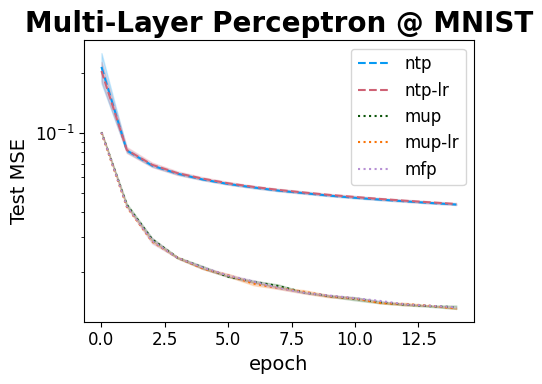

In [ ]:
plt.figure(figsize=(5, 4))

labels = ["ntp", "ntp-lr", "mup", "mup-lr", "mfp"]
colors = ['xkcd:azure', 'xkcd:rose', 'xkcd:forest', 'xkcd:orange', 'xkcd:pale purple']
ls = ["--", "--", ":", ":", ":"]
for i, label in enumerate(labels):
    acc = test_errors[i]
    mean, std = acc.mean(axis=0), acc.std(axis=0)
    epochs = np.arange(len(mean))
    plt.plot(epochs, mean, color=colors[i], label=label, ls=ls[i])
    plt.fill_between(epochs, mean-std, mean+std, alpha=0.2, color=colors[i])

import matplotlib.pyplot as plt

# Plot the title and other elements
plt.title('Multi-Layer Perceptron @ MNIST', fontsize=20, fontweight='bold')  # Title of the plot, MLP stands for Multi-Layer Perceptron, MNIST refers to the dataset.
plt.legend()  # Display a legend to label different elements or curves in the plot (e.g., training vs. test performance)
plt.yscale('log')  # Set the y-axis to logarithmic scale (often used to visualize values that span multiple orders of magnitude)
plt.ylabel('Test MSE', fontsize=14)  # Label for the y-axis (MSE stands for Mean Squared Error, a common loss metric)
plt.xlabel('epoch', fontsize=14)  # Label for the x-axis (epoch refers to the number of iterations over the training data)
plt.tight_layout()  # Automatically adjust subplot parameters for a nice fit
plt.show()  # Display the plot


In [ ]:
imdata = ImageData("fmnist", 'data')
X_train, y_train = imdata.get_dataset(5000, get='train')
X_test, y_test = imdata.get_dataset(5000, get='test')
X_train = X_train.reshape(X_train.shape[0], -1)
X_test = X_test.reshape(X_test.shape[0], -1)
X_train, y_train, X_test, y_test = [torch.Tensor(d).cuda() for d in (X_train, y_train, X_test, y_test)]

train_loader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(X_train, y_train),
                                           batch_size=64, shuffle=True)
test_loader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(X_test, y_test),
                                          batch_size=64, shuffle=False)

100%|██████████| 26.4M/26.4M [00:01<00:00, 16.9MB/s]
100%|██████████| 29.5k/29.5k [00:00<00:00, 270kB/s]
100%|██████████| 4.42M/4.42M [00:00<00:00, 5.03MB/s]
100%|██████████| 5.15k/5.15k [00:00<00:00, 21.4MB/s]


In [ ]:
ntrials = 3
nepochs = 15
test_errors = np.empty((5, ntrials, nepochs))

for i, param in enumerate(["ntp", "ntp-lr", "mup", "mup-lr", "mfp"]):
    for trial in range(ntrials):
        model = SimpleMLP(d_in=784, d_out=10, width=512).to(device)
        optimizer = torch.optim.SGD(model.parameters(), lr=1, momentum=0.9)
        mupify(model, optimizer, param=param)
        for epoch in range(nepochs):
            print('.', end='')
            test_loss, accuracy = test_error(model, test_loader)
            test_errors[i, trial, epoch] = test_loss
            for batch_idx, (data, target) in enumerate(train_loader):
                optimizer.zero_grad()
                output = model(data)
                loss = F.mse_loss(output, target)
                loss.backward()
                optimizer.step()
    print()

.............................................
.............................................
.............................................
.............................................
.............................................


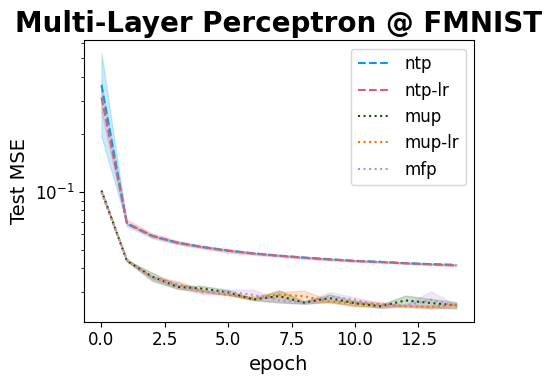

In [ ]:
plt.figure(figsize=(5, 4))

labels = ["ntp", "ntp-lr", "mup", "mup-lr", "mfp"]
colors = ['xkcd:azure', 'xkcd:rose', 'xkcd:forest', 'xkcd:orange', 'xkcd:pale purple']
ls = ["--", "--", ":", ":", ":"]
for i, label in enumerate(labels):
    acc = test_errors[i]
    mean, std = acc.mean(axis=0), acc.std(axis=0)
    epochs = np.arange(len(mean))
    plt.plot(epochs, mean, color=colors[i], label=label, ls=ls[i])
    plt.fill_between(epochs, mean-std, mean+std, alpha=0.2, color=colors[i])

import matplotlib.pyplot as plt

# Plot the title and other elements
plt.title('Multi-Layer Perceptron @ FMNIST', fontsize=20, fontweight='bold')  # Title of the plot, MLP stands for Multi-Layer Perceptron, MNIST refers to the dataset.
plt.legend()  # Display a legend to label different elements or curves in the plot (e.g., training vs. test performance)
plt.yscale('log')  # Set the y-axis to logarithmic scale (often used to visualize values that span multiple orders of magnitude)
plt.ylabel('Test MSE', fontsize=14)  # Label for the y-axis (MSE stands for Mean Squared Error, a common loss metric)
plt.xlabel('epoch', fontsize=14)  # Label for the x-axis (epoch refers to the number of iterations over the training data)
plt.tight_layout()  # Automatically adjust subplot parameters for a nice fit
plt.show()  # Display the plot


In [ ]:
class SimpleMLP(nn.Module):

    def __init__(self, d_in, d_out, width):
        super().__init__()
        self.fc1 = nn.Linear(d_in, width)
        self.fc2 = nn.Linear(width, width)
        self.fc3 = nn.Linear(width, d_out)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.fc3(x)
        return x

    def get_activations(self, x):
        h1 = self.relu(self.fc1(x))
        h2 = self.relu(self.fc2(h1))
        h3 = self.fc3(h2)
        return h1, h2, h3

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
imdata = ImageData("mnist", 'data')
X_train, y_train = imdata.get_dataset(5000, get='train')
X_test, y_test = imdata.get_dataset(5000, get='test')
X_train = X_train.reshape(X_train.shape[0], -1)
X_test = X_test.reshape(X_test.shape[0], -1)
X_train, y_train, X_test, y_test = [torch.Tensor(d).cuda() for d in (X_train, y_train, X_test, y_test)]

train_loader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(X_train, y_train),
                                           batch_size=512, shuffle=True)
test_loader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(X_test, y_test),
                                          batch_size=512, shuffle=False)

In [ ]:
ntrials = 100
widths = np.logspace(8, 12, num=10, base=2).astype(int)
update_sizes = np.empty((2, len(widths), ntrials))

for i, param in enumerate(["ntp", "mup"]):
    for j, width in enumerate(widths):
        print('.', end='')
        model = SimpleMLP(d_in=784, d_out=10, width=width).to(device)
        for trial in range(ntrials):
            optimizer = torch.optim.SGD(model.parameters(), lr=1, momentum=0.9)
            mupify(model, optimizer, param=param)

            data, target = next(iter(train_loader))
            optimizer.zero_grad()
            _, h2, h3 = model.get_activations(data)
            loss = F.mse_loss(h3, target)
            loss.backward()
            optimizer.step()
            _, h2_new, _ = model.get_activations(data)

            update_size = torch.linalg.norm(h2_new - h2) / torch.linalg.norm(h2)
            update_sizes[i, j, trial] = update_size
    print()

..........
..........


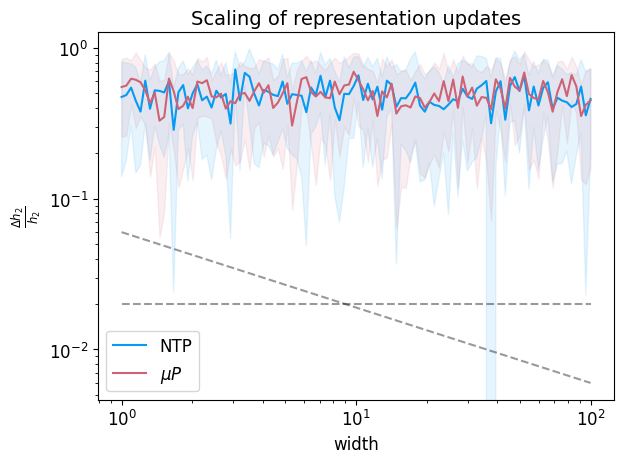

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Example data
widths = np.logspace(0, 2, 100)  # Log-spaced widths for the x-axis
update_sizes = [np.random.rand(10, len(widths)) for _ in range(2)]  # Simulated update sizes for NTP and mu P

labels = ["NTP", r"$\mu P$"]
colors = ['xkcd:azure', 'xkcd:rose']
for i, label in enumerate(labels):
    update_sz = update_sizes[i].mean(axis=0)  # Take mean along axis 0, which matches the length of widths
    update_std = update_sizes[i].std(axis=0)  # Standard deviation along axis 0
    plt.plot(widths, update_sz, color=colors[i], label=label)
    plt.fill_between(widths, update_sz-update_std, update_sz+update_std, color=colors[i], alpha=0.1)

# Adding reference lines
plt.plot(widths, 0.06*widths**(-0.5), alpha=0.4, color='k', ls='--')
plt.plot(widths, 0.02*widths**0, alpha=0.4, color='k', ls='--')

# Title and labels
plt.title('Scaling of representation updates')
plt.legend()
plt.xscale('log')
plt.yscale('log')

# Adjust label without LaTeX norm
plt.ylabel(r'$\frac{\Delta h_2}{h_2}$')  # Simplified label without norm
plt.xlabel('width')

# Layout and show the plot
plt.tight_layout()
plt.show()


In [ ]:
class SimpleMLP(nn.Module):

    def __init__(self, d_in, d_out, width):
        super().__init__()
        self.fc1 = nn.Linear(d_in, width)
        self.fc2 = nn.Linear(width, width)
        self.fc3 = nn.Linear(width, d_out)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.fc3(x)
        return x

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
imdata = ImageData("mnist", 'data')
X_train, y_train = imdata.get_dataset(2000, get='train')
X_test, y_test = imdata.get_dataset(5000, get='test')
X_train = X_train.reshape(X_train.shape[0], -1)
X_test = X_test.reshape(X_test.shape[0], -1)
X_train, y_train, X_test, y_test = [torch.Tensor(d).cuda() for d in (X_train, y_train, X_test, y_test)]

train_loader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(X_train, y_train),
                                           batch_size=64, shuffle=True)
test_loader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(X_test, y_test),
                                          batch_size=64, shuffle=False)

In [ ]:
ntrials = 5
widths = np.logspace(5, 9, num=5, base=2).astype(int)
mup_lrs = np.logspace(1, 6, num=30, base=2)
ntp_lrs = np.logspace(3, 8, num=30, base=2)
test_errors = np.empty((2, len(widths), len(mup_lrs), ntrials))

for i, param in enumerate(["ntp", "mup"]):
    lrs = mup_lrs if param=="mup" else ntp_lrs
    for j, width in enumerate(widths):
        for k, lr in enumerate(lrs):
            print('.', end='')
            model = SimpleMLP(d_in=784, d_out=10, width=width).to(device)
            for trial in range(ntrials):
                optimizer = torch.optim.SGD(model.parameters(), lr=lr, momentum=0.9)
                mupify(model, optimizer, param=param)
                for epoch in range(1):
                    for data, target in train_loader:
                        optimizer.zero_grad()
                        output = model(data)
                        loss = F.mse_loss(output, target)
                        loss.backward()
                        optimizer.step()
                test_loss, accuracy = test_error(model, test_loader)
                if not test_loss < 1e5:
                    test_loss = 1e5
                test_errors[i, j, k, trial] = test_loss
        print()

..............................
..............................
..............................
..............................
..............................
..............................
..............................
..............................
..............................
..............................


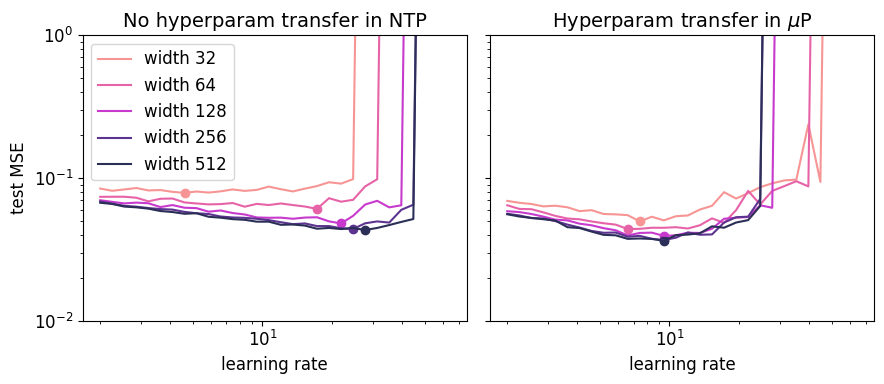

In [ ]:
fig, axes = plt.subplots(1, 2, sharey=True, figsize=(9, 4))

titles = ["No hyperparam transfer in NTP", r"Hyperparam transfer in $\mu$P"]
colors = "#2b2f57 #5c3490 #c73acd #e763a8 #f79595".split(' ')[::-1]
for i, title in enumerate(titles):
    axes[i].set_title(title)
    axes[i].set_xscale('log')
    axes[i].set_yscale('log')
    axes[i].set_ylim(1e-2, 1e0)
    axes[i].set_xlabel('learning rate')
    lrs = ntp_lrs if label=="NTP" else mup_lrs
    for j, width in enumerate(widths):
        test_err = test_errors[i, j].mean(axis=1)
        test_err[np.argwhere(test_err>1e1)[0, 0]:] = 1e5
        axes[i].plot(lrs, test_err, color=colors[j], label=f'width {width}')
        min_lr = lrs[np.argmin(test_err)]
        axes[i].scatter(min_lr, min(test_err), color=colors[j])


axes[0].legend()
axes[0].set_ylabel('test MSE')

plt.tight_layout()
plt.show()

In [ ]:
class Myrtle5(nn.Module):

    def __init__(self, chan_in=3, d_out=10, width=512):
        super().__init__()
        ksz = 3
        self.conv1 = nn.Conv2d(chan_in, width, ksz, padding='same')
        self.conv2 = nn.Conv2d(width, width, ksz, padding='same')
        self.conv3 = nn.Conv2d(width, width, ksz, padding='same')
        self.conv4 = nn.Conv2d(width, width, ksz, padding='same')
        self.readout = nn.Linear(width, d_out)
        self.pool = nn.AvgPool2d(kernel_size=2)
        self.gap = nn.AvgPool2d(kernel_size=8)
        self.relu = nn.ReLU()

    def forward(self, x):
        h1 = self.relu(self.conv1(x))
        h2 = self.pool(self.relu(self.conv2(h1)))
        h3 = self.pool(self.relu(self.conv3(h2)))
        h4 = self.gap(self.relu(self.conv4(h3)))
        return self.readout(h4.squeeze())

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
param = 'mup'    # choose one of ["ntp", "mup", "mfp", "ntp-lr", "mup-lr"].

model = Myrtle5(chan_in=3, d_out=10, width=512).to(device)
optimizer = torch.optim.SGD(model.parameters(), lr=1, momentum=0.9)
mupify(model, optimizer, param=param, verbose=True)

inp = torch.normal(0, 1, size=(256, 3, 32, 32)).cuda()
print_model_measurements(model, optimizer, inp)

== Model anatomy ==
d_in = 3
d_out = 10
widths: [512, 512, 512, 512]
	 using width = 512
readin layer: conv1
readout layer: readout

== Output scale ==
0.0364

== Init weight scale ==
conv1                0.0444
conv2                0.0442
conv3                0.0442
conv4                0.0442
readout              0.0439

== Layerwise learning rates ==
conv1                1.0000
conv2                1.0000
conv3                1.0000
conv4                1.0000
readout              1.0000


In [ ]:
imdata = ImageData("cifar10", 'data')
X_train, y_train = imdata.get_dataset(10000, get='train')
X_test, y_test = imdata.get_dataset(5000, get='test')
X_train, y_train, X_test, y_test = [torch.Tensor(d).cuda() for d in (X_train, y_train, X_test, y_test)]

train_loader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(X_train, y_train),
                                           batch_size=64, shuffle=True)
test_loader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(X_test, y_test),
                                          batch_size=64, shuffle=False)

100%|██████████| 170M/170M [00:03<00:00, 50.5MB/s]


In [ ]:
ntrials = 3
nepochs = 15
test_errors = np.empty((5, ntrials, nepochs))

for i, param in enumerate(["ntp", "ntp-lr", "mup", "mup-lr", "mfp"]):
    for trial in range(ntrials):
        model = Myrtle5(chan_in=3, d_out=10, width=128).to(device)
        optimizer = torch.optim.SGD(model.parameters(), lr=1, momentum=0.9)
        mupify(model, optimizer, param=param)
        for epoch in range(nepochs):
            print('.', end='')
            test_loss, accuracy = test_error(model, test_loader)
            test_errors[i, trial, epoch] = test_loss
            for batch_idx, (data, target) in enumerate(train_loader):
                optimizer.zero_grad()
                output = model(data)
                loss = F.mse_loss(output, target)
                loss.backward()
                optimizer.step()
    print()

.............................................
.............................................
.............................................
.............................................
.............................................


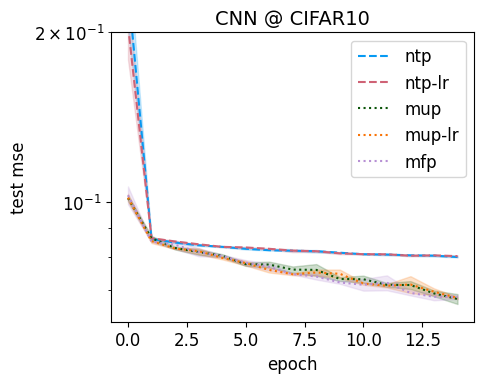

In [ ]:
plt.figure(figsize=(5, 4))

labels = ["ntp", "ntp-lr", "mup", "mup-lr", "mfp"]
colors = ['xkcd:azure', 'xkcd:rose', 'xkcd:forest', 'xkcd:orange', 'xkcd:pale purple']
ls = ["--", "--", ":", ":", ":"]
for i, label in enumerate(labels):
    acc = test_errors[i]
    mean, std = acc.mean(axis=0), acc.std(axis=0)
    epochs = np.arange(len(mean))
    plt.plot(epochs, mean, color=colors[i], label=label, ls=ls[i])
    plt.fill_between(epochs, mean-std, mean+std, alpha=0.2, color=colors[i])

plt.title('CNN @ CIFAR10')
plt.legend()
plt.yscale('log')
plt.ylabel('test mse')
plt.ylim(top=0.2)
plt.xlabel('epoch')
plt.tight_layout()
plt.show()

In [ ]:
imdata = ImageData("cifar100", 'data')
X_train, y_train = imdata.get_dataset(10000, get='train')
X_test, y_test = imdata.get_dataset(5000, get='test')
X_train, y_train, X_test, y_test = [torch.Tensor(d).cuda() for d in (X_train, y_train, X_test, y_test)]

train_loader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(X_train, y_train),
                                           batch_size=64, shuffle=True)
test_loader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(X_test, y_test),
                                          batch_size=64, shuffle=False)

100%|██████████| 169M/169M [00:01<00:00, 102MB/s]


In [ ]:
ntrials = 3
nepochs = 15
test_errors = np.empty((5, ntrials, nepochs))

for i, param in enumerate(["ntp", "ntp-lr", "mup", "mup-lr", "mfp"]):
    for trial in range(ntrials):
        model = Myrtle5(chan_in=3, d_out=10, width=128).to(device)
        optimizer = torch.optim.SGD(model.parameters(), lr=1, momentum=0.9)
        mupify(model, optimizer, param=param)
        for epoch in range(nepochs):
            print('.', end='')
            test_loss, accuracy = test_error(model, test_loader)
            test_errors[i, trial, epoch] = test_loss
            for batch_idx, (data, target) in enumerate(train_loader):
                optimizer.zero_grad()
                output = model(data)
                loss = F.mse_loss(output, target)
                loss.backward()
                optimizer.step()
    print()

.

<ipython-input-5-f776fffe80d0>:9: UserWarning: Using a target size (torch.Size([64, 100])) that is different to the input size (torch.Size([64, 10])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  test_loss += F.mse_loss(output, target, reduction='sum').item() / d_out


RuntimeError: The size of tensor a (10) must match the size of tensor b (100) at non-singleton dimension 1

In [ ]:
class MyrtleMixer5(nn.Module):

    def __init__(self, chan_in=3, d_out=10, width=512):
        super().__init__()
        ksz = 5
        self.conv1 = nn.Conv2d(chan_in, width, ksz, padding='same')
        self.conv2 = nn.Conv2d(width, width, ksz, groups=width, padding='same')
        self.mlp2 = nn.Conv2d(width, width, 1, padding='same')
        self.conv3 = nn.Conv2d(width, width, ksz, groups=width, padding='same')
        self.mlp3 = nn.Conv2d(width, width, 1, padding='same')
        self.conv4 = nn.Conv2d(width, width, ksz, groups=width, padding='same')
        self.mlp4 = nn.Conv2d(width, width, 1, padding='same')
        self.readout = nn.Linear(width, d_out)
        self.pool = nn.AvgPool2d(kernel_size=2)
        self.gap = nn.AvgPool2d(kernel_size=8)
        self.relu = nn.ReLU()

    def forward(self, x):
        h1 = self.relu(self.conv1(x))
        h2 = self.pool(self.relu(self.mlp2(self.conv2(h1))))
        h3 = self.pool(self.relu(self.mlp3(self.conv3(h2))))
        h4 = self.gap(self.relu(self.mlp4(self.conv4(h3))))
        return self.readout(h4.squeeze())

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
param = 'ntp-lr'

model = MyrtleMixer5(chan_in=3, d_out=10, width=512).to(device)
optimizer = torch.optim.SGD(model.parameters(), lr=1, momentum=0.9)
mupify(model, optimizer, param=param, verbose=True)

inp = torch.normal(0, 1, size=(256, 3, 32, 32)).cuda()
print_model_measurements(model, optimizer, inp)

== Model anatomy ==
d_in = 3
d_out = 10
widths: [512, 512, 512, 512, 512, 512, 512]
	 using width = 512
readin layer: conv1
readout layer: readout

== Output scale ==
0.9390

== Init weight scale ==
conv1                0.1150
conv2                0.2025
mlp2                 0.0442
conv3                0.1990
mlp3                 0.0441
conv4                0.1988
mlp4                 0.0442
readout              0.0444

== Layerwise learning rates ==
conv1                0.0133
conv2                0.0400
mlp2                 0.0020
conv3                0.0400
mlp3                 0.0020
conv4                0.0400
mlp4                 0.0020
readout              0.0020


In [ ]:
imdata = ImageData("cifar10", 'data')
X_train, y_train = imdata.get_dataset(10000, get='train')
X_test, y_test = imdata.get_dataset(5000, get='test')
X_train, y_train, X_test, y_test = [torch.Tensor(d).cuda() for d in (X_train, y_train, X_test, y_test)]

train_loader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(X_train, y_train),
                                           batch_size=64, shuffle=True)
test_loader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(X_test, y_test),
                                          batch_size=64, shuffle=False)

In [ ]:
WIDTH = 128
ntrials = 3
nepochs = 15
test_errors = np.empty((2, ntrials, nepochs))

for i, param in enumerate(["ntp", "mup"]):
    for trial in range(ntrials):
        model = MyrtleMixer5(chan_in=3, d_out=10, width=WIDTH).to(device)
        optimizer = torch.optim.SGD(model.parameters(), lr=1, momentum=0.9)
        mupify(model, optimizer, param=param)
        for epoch in range(nepochs):
            print('.', end='')
            test_loss, accuracy = test_error(model, test_loader)
            test_errors[i, trial, epoch] = test_loss
            for batch_idx, (data, target) in enumerate(train_loader):
                optimizer.zero_grad()
                output = model(data)
                loss = F.mse_loss(output, target)
                loss.backward()
                optimizer.step()
    print()

.............................................
.............................................


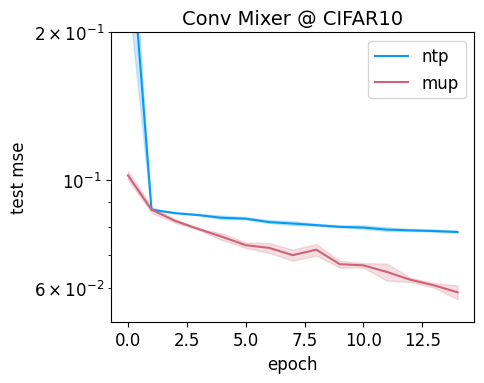

In [ ]:
plt.figure(figsize=(5, 4))

labels = ["ntp", "mup"]
colors = ['xkcd:azure', 'xkcd:rose']
for i, label in enumerate(labels):
    acc = test_errors[i]
    mean, std = acc.mean(axis=0), acc.std(axis=0)
    epochs = np.arange(len(mean))
    plt.plot(epochs, mean, color=colors[i], label=label)
    plt.fill_between(epochs, mean-std, mean+std, alpha=0.2, color=colors[i])

plt.title('Conv Mixer @ CIFAR10')
plt.legend()
plt.yscale('log')
plt.ylabel('test mse')
plt.ylim(top=0.2)
plt.xlabel('epoch')
plt.tight_layout()
plt.show()